In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Study the data

In [2]:
data = pd.read_csv('data.csv', sep='\t', engine='python')
data.head()

,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,...,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_click,date
0,2744506471184009586,7908382889764677758;7258015885215914736,5131280576272319091;2636395404473730413;751580...,7838285046767229711,5918626470536001929,4,11,10,17,545400486120000430,...,7258015885215914736:9148482949976129397;509660...,7298587034305908007,9,0.979905,5007,0.965576,0.970909,0.959273,0,2018-09-18
1,9148952645395028291,7908382889764677758;5755694407684602296,5131280576272319091;6434796455031995313;914848...,4609398715869550725,7322157373578955368,7,11,12,18,2288811001379435459,...,"5755694407684602296:1725845221699571933,403435...",4629590182417672844,18,0.991784,5015,0.970960,0.969867,0.969540,0,2018-09-18
2,4612236884975741646,7908382889764677758;7258015885215914736,5131280576272319091;2636395404473730413;734498...,6793286343174833903,196257267849351217,5,14,14,19,4922845833114612534,...,7258015885215914736:9148482949976129397;509660...,2025576994711098052,17,1.000000,5014,0.978163,0.977253,0.987147,1,2018-09-18
3,8238195786294017989,7908382889764677758;8277336076276184272,2636395404473730413;1243768796732904674;101341...,7066302540842412840,3948283326616421003,7,7,10,16,4721760060928545832,...,8277336076276184272:-1;7908382889764677758:263...,6597981382309269962,21,0.997040,5018,0.979661,0.979589,0.975442,0,2018-09-18
4,5628071872190948042,7908382889764677758;8277336076276184272,5131280576272319091;2636395404473730413;462193...,223136115558074817,7534238860363577544,8,12,15,17,5077257571429508003,...,"836752724084922533:3605305489057951035,7557400...",323195289690023120,16,1.000000,5013,0.974115,0.974751,0.981497,0,2018-09-18


In [3]:
data.dtypes

item_id                        int64
item_category_list            object
item_property_list            object
item_brand_id                  int64
item_city_id                   int64
item_price_level               int64
item_sales_level               int64
item_collected_level           int64
item_pv_level                  int64
user_id                        int64
user_gender_id                 int64
user_age_level                 int64
user_occupation_id             int64
user_star_level                int64
context_id                     int64
context_timestamp              int64
context_page_id                int64
predict_category_property     object
shop_id                        int64
shop_review_num_level          int64
shop_review_positive_rate    float64
shop_star_level                int64
shop_score_service           float64
shop_score_delivery          float64
shop_score_description       float64
is_click                       int64
date                          object
d

In [16]:
data.shape

(55933, 27)

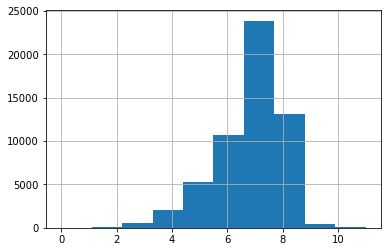

In [15]:
data['item_price_level'].hist().plot(kind='bar')
plt.show()

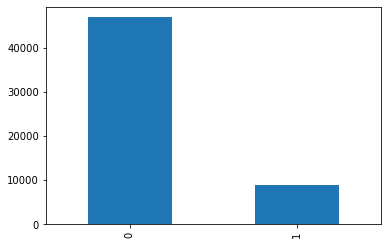

In [19]:
data['is_click'].value_counts().plot(kind='bar')
plt.show()

In [20]:
data['item_id'].nunique()

5702

In [21]:
data['user_id'].nunique()

47180

In [28]:
data.groupby('date')['is_click'].mean().reset_index()

,date,is_click
0,2018-09-18,0.168404
1,2018-09-19,0.167567
2,2018-09-20,0.167045
3,2018-09-21,0.163729
4,2018-09-22,0.162794
5,2018-09-23,0.148233
6,2018-09-24,0.146213


# Build features

In [69]:
CATEGORICAL_FEATURES = ['item_city_id', 'user_gender_id', 'user_occupation_id']
CONTINUOUS_FEATURES = ['item_price_level', 'item_sales_level', 'item_collected_level',
                       'item_pv_level', 'user_age_level', 'user_star_level',
                       'shop_review_num_level', 'shop_review_positive_rate',
                       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
                       'shop_score_description']
VECTOR_FEATURES = ['item_category_list']

In [118]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify = y, random_state=2021) 
data_train = data[data['date'] != '2018-09-21']
data_test = data[data['date'] == '2018-09-21']
y_train = data[data['date'] != '2018-09-21']['is_click']
y_test = data[data['date'] == '2018-09-21']['is_click']
print(data_train.shape, y_train.shape)

(47535, 27) (47535,)


continuous

In [119]:
# x_train_continuous = (data_train[CONTINUOUS_FEATURES].values - data_train[CONTINUOUS_FEATURES].values.mean()) / data_train[CONTINUOUS_FEATURES].values.std()
# x_test_continuous = (data_test[CONTINUOUS_FEATURES].values - data_test[CONTINUOUS_FEATURES].values.mean()) / data_test[CONTINUOUS_FEATURES].values.std()

x_train_continuous = data_train[CONTINUOUS_FEATURES].values
x_test_continuous = data_test[CONTINUOUS_FEATURES].values

categorical

In [120]:
one_hot = OneHotEncoder()
one_hot.fit(pd.concat([data_train[CATEGORICAL_FEATURES], data_test[CATEGORICAL_FEATURES]], axis=0).values)
x_train_categorical = one_hot.transform(data_train[CATEGORICAL_FEATURES].values).toarray()
x_test_categorical = one_hot.transform(data_test[CATEGORICAL_FEATURES].values).toarray()
x_train_categorical

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

vector

In [121]:
x_train_vector, x_test_vector = None, None

for feature in VECTOR_FEATURES: 
    vectorizer = CountVectorizer()
    vectorizer.fit(pd.concat([data_train[feature], data_test[feature]], axis=0).values)
    if x_train_vector is None: 
        x_train_vector = vectorizer.transform(data_train[feature].values).toarray()
        x_test_vector = vectorizer.transform(data_test[feature].values).toarray()
    else: 
        x_train_vector = np.hstack([x_train_vector, vectorizer.transform(data_train[feature].values).toarray()])
        x_test_vector = np.hstack([x_test_vector, vectorizer.transform(data_test[feature].values).toarray()])

# GBDT for continuous features

In [122]:
gbm = GradientBoostingClassifier(n_estimators=50, max_depth=4, random_state=2021, verbose=1)
gbm.fit(x_train_continuous, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8741            2.84s
         2           0.8678            2.75s
         3           0.8628            2.67s
         4           0.8585            2.61s
         5           0.8550            2.56s
         6           0.8518            2.49s
         7           0.8493            2.44s
         8           0.8471            2.39s
         9           0.8452            2.33s
        10           0.8431            2.27s
        20           0.8310            1.73s
        30           0.8238            1.16s
        40           0.8188            0.58s
        50           0.8147            0.00s


GradientBoostingClassifier(max_depth=4, n_estimators=50, random_state=2021,
                           verbose=1)

In [123]:
x_train_gmb_raw = np.squeeze(gbm.apply(x_train_continuous))
x_test_gmb_raw = np.squeeze(gbm.apply(x_test_continuous))

In [124]:
one_hot = OneHotEncoder()
one_hot.fit(x_train_gmb_raw)
x_train_gmb = one_hot.transform(x_train_gmb_raw).toarray()
x_test_gmb = one_hot.transform(x_test_gmb_raw).toarray()

# LR for all features

In [125]:
x_train_all = np.hstack([x_train_gmb, x_train_categorical, x_train_vector])
x_test_all = np.hstack([x_test_gmb, x_test_categorical, x_test_vector])

In [126]:
lr = LogisticRegression(C=100, max_iter=500, n_jobs=8)
lr.fit(x_train_all, y_train)

LogisticRegression(C=100, max_iter=500, n_jobs=8)

In [127]:
prob = lr.predict_proba(x_test_all)
roc_auc_score(y_test, prob[:, 1])

0.6711082288066483